# Load Pre-trained model and tokenizer

In [4]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.__version__)
print(torch.cuda.get_device_name(0))

True
12.1
2.6.0.dev20241112+cu121
Tesla V100S-PCIE-32GB


In [5]:
# 已经把模型下载到本地 /wubohui/models/Qwen3-4B-Instruct-2507
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_path = "/wubohui/models/Qwen3-4B-Instruct-2507"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load tokenizer from local folder
tokenizer = AutoTokenizer.from_pretrained(
    model_path,
    trust_remote_code=True
)

# Load model from local folder
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

print("Qwen3-4B loaded successfully!")

Loading checkpoint shards: 100%|██████████| 3/3 [00:10<00:00,  3.49s/it]

Qwen3-4B loaded successfully!


Then we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [6]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [7]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [8]:
from peft import LoraConfig, get_peft_model
# You can try differnt parameter-effient strategy for model trianing, for more info, please check https://github.com/huggingface/peft
config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)

In [9]:
from fastchat.conversation import get_conv_template
device = "cuda"
model.eval()

@torch.no_grad()
def generate(prompt):
    input_ids = tokenizer.encode(prompt, add_special_tokens=False, return_tensors='pt').to(device)
    outputs = model.generate(input_ids, do_sample=False, max_new_tokens=1024)
    return tokenizer.decode(*outputs, skip_special_tokens=True)

prompt = "Give me a short introduction to large language model."
messages = [
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
)
response = generate(text)
print("-"*80)
print(response)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


--------------------------------------------------------------------------------
user
Give me a short introduction to large language model.
assistant
A large language model (LLM) is a type of artificial intelligence system trained on vast amounts of text from the internet to understand and generate human-like language. These models use deep learning techniques, particularly transformer architectures, to learn patterns, grammar, and context in natural language. Once trained, LLMs can perform a wide range of tasks such as answering questions, writing stories, translating languages, summarizing text, and more—often producing responses that are coherent and contextually relevant. Examples include GPT-3, BERT, and Llama. While powerful, they can sometimes produce inaccurate or biased information and require careful use and oversight.


# Data Preparation

In [10]:
from datasets import load_dataset

dataset = load_dataset(
    "json",
    data_files="/wubohui/datasets/FreedomIntelligence/Huatuo26M-Lite/format_data.jsonl",
    split="train[:10%]"
)

print("Raw example:", dataset[0])

# Correct format function
def format_huatuo(example):
    return {
        "instruction": example["question"],
        "input": "",
        "output": example["answer"]
    }

dataset = dataset.map(format_huatuo)
dataset = dataset.shuffle(seed=42)

print("Formatted example:", dataset[0])
print("Dataset size:", len(dataset))

Raw example: {'id': 22647835, 'answer': '治疗鼻中隔偏曲的方法有手术和非手术治疗两种，手术治疗是通过手术矫正鼻中隔偏曲，非手术治疗则是通过药物治疗和物理治疗来缓解症状。手术治疗是治疗鼻中隔偏曲的最有效方法，手术后需要注意休息，避免剧烈运动和低头工作，同时也要注意饮食，少吃辛辣食物和不喝酒。手术后两周内鼻涕或痰中出现血水或血块是正常现象，若出现大量出血、发烧、剧烈疼痛时请尽速就医。', 'score': 5, 'label': '眼耳鼻喉科', 'question': '上个月感冒了，也没有用药，感冒好了以后就觉得鼻子经常不通畅，鼻子还经常晦气红皮、发痒、而且还会有头晕，一直都以为是上次感冒留下的后遗症，去医院检查，检查结果出来以后说是鼻中隔偏曲。请问如何治疗鼻中隔偏曲？', 'related_diseases': '鼻中隔偏曲'}
Formatted example: {'id': 6393825, 'answer': '视力疲劳的原因是长时间近距离工作导致眼睛肌肉疲劳。对于高度近视眼来说，工作距离很近，眼睛需要过度调节，导致内直肌使用过多，进而引起视力疲劳症状。为了缓解视力疲劳，可以尝试以下治疗建议：\n1. 定期休息：长时间近距离工作后，应该给眼睛充分休息的时间，每隔一段时间闭目休息或看远处的景物，让眼睛得到放松。\n2. 眼保健操：进行眼保健操可以帮助舒缓眼部肌肉，减轻视力疲劳的症状。可以在工作间隙进行眼部按摩、眼球转动等眼保健操。\n3. 保持良好的工作姿势：保持正确的工作姿势，避免过度用眼和过度调节，可以减轻眼睛的负担。\n4. 调整工作环境：保持适当的光线和距离，避免过暗或过亮的环境，调整工作距离，使眼睛不需要过度调节。\n5. 补充营养：维生素A、维生素B、葫萝卜素和屈光不正与视力疲劳有很大的相关性。此外，维生素C、维生素B6和锌的补充也可以帮助解决眼睛问题。可以适量摄入含有这些营养物质的食物或考虑适当的补充剂。\n\n如果以上方法无法缓解视力疲劳症状，建议咨询眼科医生进行进一步的检查和治疗。', 'score': 4, 'label': '眼耳鼻喉科', 'question': '我有轻度或中度近视，除视远物模糊外，并无其它症状，在近距离工作时，不需调节或少用调节即可看清细小目标，反而感到方便。但在高度近视眼，

In [11]:
def build_prompt(example):
    example["messages"] = [
        {"role": "user", "content": example["instruction"]}
    ]
    example["answer"] = example["output"]
    return example

dataset = dataset.map(build_prompt)

In [12]:
def tokenize(example):
    # 使用 chat_template 自动构建 prompt
    prompt = tokenizer.apply_chat_template(
        example["messages"],
        tokenize=False,
        add_generation_prompt=True
    )

    full_text = prompt + example["answer"]

    tokenized = tokenizer(
        full_text,
        truncation=True,
        max_length=512,
        padding="max_length"
    )

    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized

tokenized_dataset = dataset.map(tokenize, remove_columns=dataset.column_names)

In [13]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=64,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)

/wubohui/conda_envs/NLP_hw3/lib/python3.10/site-packages/peft/mapping_func.py:72: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/wubohui/conda_envs/NLP_hw3/lib/python3.10/site-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


# Training

## General Training Hyperparameters

In [14]:
from transformers import TrainingArguments
import inspect
print(inspect.signature(TrainingArguments.__init__))

(self, output_dir: Optional[str] = None, overwrite_output_dir: bool = False, do_train: bool = False, do_eval: bool = False, do_predict: bool = False, eval_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no', prediction_loss_only: bool = False, per_device_train_batch_size: int = 8, per_device_eval_batch_size: int = 8, per_gpu_train_batch_size: Optional[int] = None, per_gpu_eval_batch_size: Optional[int] = None, gradient_accumulation_steps: int = 1, eval_accumulation_steps: Optional[int] = None, eval_delay: Optional[float] = 0, torch_empty_cache_steps: Optional[int] = None, learning_rate: float = 5e-05, weight_decay: float = 0.0, adam_beta1: float = 0.9, adam_beta2: float = 0.999, adam_epsilon: float = 1e-08, max_grad_norm: float = 1.0, num_train_epochs: float = 3.0, max_steps: int = -1, lr_scheduler_type: Union[transformers.trainer_utils.SchedulerType, str] = 'linear', lr_scheduler_kwargs: Union[dict[str, Any], str, NoneType] = <factory>, warmup_ratio: float = 0.0, 

In [15]:
import transformers

training_arguments = transformers.TrainingArguments(
    output_dir="/wubohui/ipynb/output_dir/",
    num_train_epochs=1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=1,   # V100 避免评估占太多显存
    gradient_accumulation_steps=4,  # 提高等效 batch_size，不浪费显存
    optim="paged_adamw_32bit",

    learning_rate=2e-4,             # QLoRA 最推荐的学习率
    warmup_ratio=0.1,               # 训练更加稳定
    weight_decay=0.01,

    logging_steps=10,
    logging_strategy="steps",   # 每若干 step 记录一次
    
    eval_strategy="steps",
    eval_steps=100,

    save_strategy="epoch",          # 每个 epoch 保存 LoRA 权重
    gradient_checkpointing=True,

    fp16=True,                      # V100 必须用 fp16
    bf16=False,                     # 3090/A100 才能用

    lr_scheduler_type="cosine",
    report_to="none"
)

In [16]:
# 划分 98% 训练集 + 2% 验证集
dataset_split = tokenized_dataset.train_test_split(test_size=0.02, seed=42)
train_dataset = dataset_split["train"]
eval_dataset = dataset_split["test"]

model.train()

trainer = transformers.Trainer(
    model=model,
    args=training_arguments,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [17]:
model.print_trainable_parameters()

trainable params: 47,185,920 || all params: 4,069,654,016 || trainable%: 1.1595


In [20]:
trainer.train()

Step,Training Loss,Validation Loss
100,0.708400,0.708038
200,0.641800,0.672611
300,0.685800,0.664814
400,0.651400,0.659665
500,0.628000,0.646019
600,0.623100,0.635438
700,0.617500,0.633355
800,0.636700,0.631798
900,0.658000,0.630324
1000,0.617800,0.629231


TrainOutput(global_step=2177, training_loss=0.6358921879412223, metrics={'train_runtime': 8793.7394, 'train_samples_per_second': 1.98, 'train_steps_per_second': 0.248, 'total_flos': 1.970602052639785e+17, 'train_loss': 0.6358921879412223, 'epoch': 1.0})

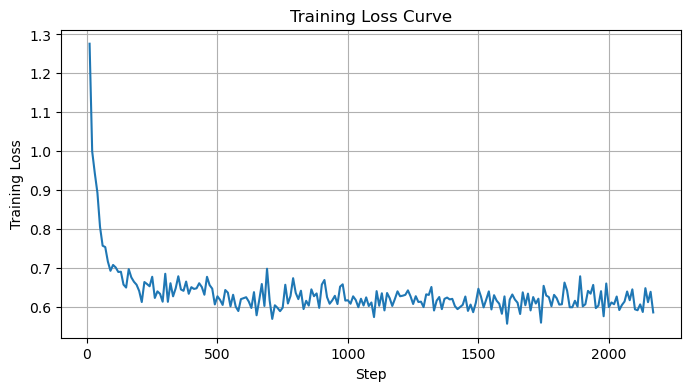

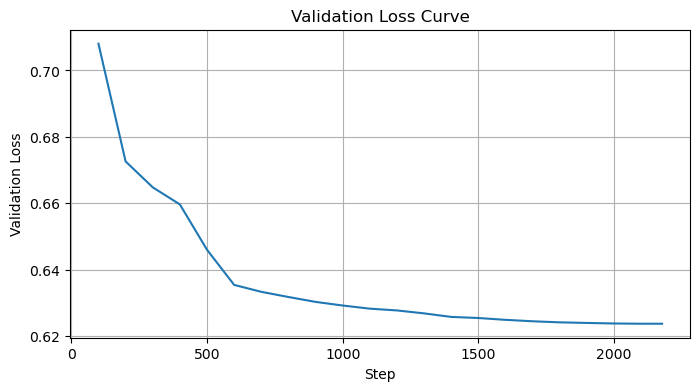

Saved figures to: /wubohui/figures/


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Directory to save figures
save_dir = "/wubohui/figures/"
os.makedirs(save_dir, exist_ok=True)

logs = trainer.state.log_history
df = pd.DataFrame(logs)

# Training Loss Curve
train_loss = df[df["loss"].notnull()][["step", "loss"]]

plt.figure(figsize=(8, 4))
plt.plot(train_loss["step"], train_loss["loss"])
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve")
plt.grid(True)

plt.savefig(os.path.join(save_dir, "train_loss.png"), dpi=300, bbox_inches="tight")
plt.show()

# Validation Loss Curve
val_loss = df[df["eval_loss"].notnull()][["step", "eval_loss"]]

plt.figure(figsize=(8, 4))
plt.plot(val_loss["step"], val_loss["eval_loss"])
plt.xlabel("Step")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Curve")
plt.grid(True)

plt.savefig(os.path.join(save_dir, "val_loss.png"), dpi=300, bbox_inches="tight")
plt.show()

print("Saved figures to:", save_dir)

Once the training is completed, we can evaluate our model and get its perplexity on the validation set like this:

In [ ]:
import math
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

## Save Trained LoRA

In [29]:
# /wubohui/ipynb/output_lora

output_path = "/wubohui/ipynb/output_lora/"
trainer.save_model(output_path)

## Test the trained model

In [30]:
from fastchat.conversation import get_conv_template
import torch

device = "cuda"
model = trainer.model.eval()

@torch.no_grad()
def generate(prompt):
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

    outputs = model.generate(
        input_ids,
        max_new_tokens=512,
        do_sample=True,
        temperature=0.7,
        top_p=0.9
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


prompt = "Give me a short introduction to large language model."

messages = [
    {"role": "user", "content": prompt}
]

# Qwen3 必须使用 apply_chat_template
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
)

response = generate(text)

print("-" * 80)
print(response)

--------------------------------------------------------------------------------
user
Give me a short introduction to large language model.
assistant
Large language models are a type of artificial intelligence that can generate human-like text. They are trained on large datasets of text and can understand and generate natural language. Large language models can be used for a variety of tasks such as translation, summarization, and question answering. They are becoming increasingly popular in natural language processing applications.


## Load the trained model back and integrate the trained LoRA within

In [ ]:
from peft import PeftModel
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_path = "/wubohui/models/Qwen3-4B-Instruct-2507"
lora_output_path = "/wubohui/ipynb/output_lora"   # 你 trainer.save_model() 的路径

# 4-bit 配置（与训练时一致
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# 加载 4bit base model
model = AutoModelForCausalLM.from_pretrained(
    base_model_path,
    quantization_config=bnb_config,
    device_map="auto"
)

# 加载 LoRA adapter
model = PeftModel.from_pretrained(
    model,
    lora_output_path,
)

# 合并 LoRA
model = model.merge_and_unload()
model.config.max_length = 512
model.eval()

# 加载 tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_path)

Loading checkpoint shards: 100%|██████████| 3/3 [00:21<00:00,  7.27s/it]
/wubohui/conda_envs/NLP_hw3/lib/python3.10/site-packages/peft/peft_model.py:598: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight', 'base_model.model.model.layers.1.self_attn.q_proj.lora_A.default.weight', 'base_model.model.model.layers.1.self_attn.q_proj.lora_B.default.weight', 'base_model.model.model.layers.1.se

## Answer generation

In [ ]:
import torch
from tqdm import tqdm

@torch.no_grad()
def generate_answers(query_list, max_new_tokens=256, temperature=0.7, top_p=0.9):
    
    # 对每条 query 生成 Qwen3 的对话 prompt
    prompts = [
        tokenizer.apply_chat_template(
            [{"role": "user", "content": query}],
            tokenize=False,
            add_generation_prompt=True
        )
        for query in query_list
    ]
    
    # tokenizer 批量编码
    inputs = tokenizer(
        prompts,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to("cuda")

    # 逐条生成（避免显存爆炸）
    outputs = []
    for i in tqdm(range(len(query_list))):
        output_ids = model.generate(
            input_ids=inputs["input_ids"][i:i+1],
            attention_mask=inputs["attention_mask"][i:i+1],
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=temperature,
            top_p=top_p
        )
        outputs.append(output_ids[0])

    # 解码
    responses = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    # 去掉 prompt，只保留 Assistant 的回答
    cleaned = []
    for prompt, response in zip(prompts, responses):
        cleaned.append(response[len(prompt):].strip())

    return cleaned

queries = [
    "What's the weather like today?",
    "Who are you?"
]

answers = generate_answers(queries)
for q, a in zip(queries, answers):
    print("Q:", q)
    print("A:", a)
    print("-" * 80)

100%|██████████| 2/2 [00:11<00:00,  5.88s/it]

Q: What's the weather like today?
A: updates. To find out the current weather, I recommend checking a reliable weather website or app like Weather.com, AccuWeather, or your phone’s built-in weather tool. Let me know your location, and I can help you interpret the forecast! 🌤️
--------------------------------------------------------------------------------
Q: Who are you?
A: model developed by Alibaba Cloud's Tongyi Lab. I can assist you with answering questions, writing, logical reasoning, programming, and more. I am proficient in 100 languages, including Chinese, English, German, French, Spanish, and others. If you have any questions or need help, feel free to let me know!
--------------------------------------------------------------------------------


## Evaluate a trained model on a given test dataset

In [35]:
import json
import os

test_file = "/wubohui/tmp/zh_med.json"
assert os.path.exists(test_file), "Invalid test_file path!"

with open(test_file, 'r', encoding='utf-8') as reader:
    test_data = json.load(reader)

print("样例：", test_data[0])
print("共加载测试样本：", len(test_data))

样例： ['什么是医学伦理学，它在医疗领域有何重要性？', '医学伦理学是研究医疗领域伦理问题的学科。它涉及研究医疗专业人员、患者和其他相关利益相关者之间的伦理关系，以及在医疗实践中出现的道德困境。\n\n医学伦理学在医疗领域具有以下重要性：\n\n1. 保护患者权益：医学伦理学关注患者的权益和尊严。它确保医疗决策是以患者的最大利益为出发点，并尊重患者的自主权和知情同意权。\n\n2. 促进医务人员职业道德：医学伦理学提供了医务人员在面对道德困境时的指导原则，帮助他们保持专业的道德标准和行为规范。\n\n3. 增加医疗决策的公正性：医学伦理学关注公正和公平的医疗分配原则。它确保资源在医疗领域的分配是公正和可持续的。\n\n4. 促进研究伦理：医学伦理学对医学研究进行伦理审查，确保研究参与者的权益和福利得到保护，并确保研究过程是符合伦理标准的。\n\n5. 保护医疗机构声誉：医学伦理学的遵循有助于确保医疗机构遵守伦理原则，保护其声誉和公众信任度。\n\n总之，医学伦理学在医疗领域的重要性在于维护患者权益、指导医务人员的职业道德行为、促进医疗决策公正和保护医学研究伦理。它为医疗行业提供了一个道德框架，确保医疗服务的质量和道德高于一切。']
共加载测试样本： 20


In [37]:
from fastchat.conversation import get_conv_template
import torch
from tqdm import tqdm

device = "cuda"
model.eval()

@torch.no_grad()
def generate_batch(query_list):
    outputs = []

    for q in tqdm(query_list):
        messages = [{"role": "user", "content": q}]
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )

        input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)

        out = model.generate(
            input_ids,
            max_new_tokens=256,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
        )

        response = tokenizer.decode(out[0], skip_special_tokens=True)
        # 去掉 prompt 之前的内容
        answer = response[len(text):].strip()

        outputs.append(answer)

    return outputs

    model_answers = generate_batch([item[0] for item in test_data])

In [40]:
import json
from fastchat.conversation import get_conv_template
import torch
from tqdm import tqdm

device = "cuda"

# ① 读取测试集
test_file = "/wubohui/tmp/zh_med.json"
with open(test_file, "r", encoding="utf-8") as f:
    test_data = json.load(f)

# ② 定义批量生成函数
@torch.no_grad()
def generate_batch(query_list):
    outputs = []

    for q in tqdm(query_list):
        messages = [{"role": "user", "content": q}]
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )

        input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)

        out = model.generate(
            input_ids,
            max_new_tokens=1024,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
        )

        response = tokenizer.decode(out[0], skip_special_tokens=True)
        answer = response[len(text):].strip()

        outputs.append(answer)

    return outputs

# 生成答案
model_answers = generate_batch([item[0] for item in test_data])

# 写回 test_data
for data, answer in zip(test_data, model_answers):
    data.append(answer)

# 保存
output_json = "/wubohui/tmp/zh_med_output.json"
with open(output_json, "w", encoding="utf-8") as f:
    json.dump(test_data, f, indent=4, ensure_ascii=False)

print("已生成并保存到：", output_json)
print("示例：", test_data[0])

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [21:54<00:00, 65.70s/it]

已生成并保存到： /wubohui/tmp/zh_med_output.json
示例： ['什么是医学伦理学，它在医疗领域有何重要性？', '医学伦理学是研究医疗领域伦理问题的学科。它涉及研究医疗专业人员、患者和其他相关利益相关者之间的伦理关系，以及在医疗实践中出现的道德困境。\n\n医学伦理学在医疗领域具有以下重要性：\n\n1. 保护患者权益：医学伦理学关注患者的权益和尊严。它确保医疗决策是以患者的最大利益为出发点，并尊重患者的自主权和知情同意权。\n\n2. 促进医务人员职业道德：医学伦理学提供了医务人员在面对道德困境时的指导原则，帮助他们保持专业的道德标准和行为规范。\n\n3. 增加医疗决策的公正性：医学伦理学关注公正和公平的医疗分配原则。它确保资源在医疗领域的分配是公正和可持续的。\n\n4. 促进研究伦理：医学伦理学对医学研究进行伦理审查，确保研究参与者的权益和福利得到保护，并确保研究过程是符合伦理标准的。\n\n5. 保护医疗机构声誉：医学伦理学的遵循有助于确保医疗机构遵守伦理原则，保护其声誉和公众信任度。\n\n总之，医学伦理学在医疗领域的重要性在于维护患者权益、指导医务人员的职业道德行为、促进医疗决策公正和保护医学研究伦理。它为医疗行业提供了一个道德框架，确保医疗服务的质量和道德高于一切。', '为规范的学科。它探讨医生、患者、医疗团队、科研人员以及卫生政策制定者在医疗活动中应遵循的道德标准和行为准则，旨在确保医疗行为在尊重生命、保障人权、促进公正与诚信的基础上进行。\n\n医学伦理学的核心原则通常包括以下四个方面：\n\n1. **尊重自主性（Respect for Autonomy）**  \n   指尊重患者作为个体对其身体和医疗决策的自主权，如知情同意、拒绝治疗等。患者有权了解自己的病情、治疗方案及其风险，并根据自身价值观做出选择。\n\n2. **不伤害/不伤害原则（Non-maleficence）**  \n   医疗行为应尽量避免造成伤害。医生应避免无意或有意地对患者造成身体、心理或社会上的伤害。\n\n3. **行善（Beneficence）**  \n   医生有责任采取有益于患者健康和福祉的行动，积极促进患者康复与生活质量。\n\n4. **公正（Justice）**  \n   医疗资源应公平分配，避免歧视，确保所有患者，